**CIS 545 - Rohan Chhaya, Elaine Fan, Kenny Liou**

## **0.** Introduction

For our project, we wanted to explore Open Food Facts, a Kaggle dataset. Specifically, our project has several goals. First, we wanted to conduct some data cleaning and do some descriptive analysis, such as looking at the top countries with the highest nutrition scores. We also looked at a breakdown of the ingredients list and the most common ingredients we can see today from products around the world. Additionally, we looked at the companies that are selling the most products on the market. We also took a glimpse at the nutrition information on the labels and compared different nutrition labels. We summarized our findings in various visualizations, such as boxplots, heat maps, wordclouds, and pie charts. 

Next, we looked at building supervised machine learning models (both regression and classification), to see if we could predict the health scores and general "healthiness" of various products based on relevant features. This included a variety of linear regression and logistic regression (unregularized and regularized), PCA, Random Forests, and Neural Networks. 

Let's start with uploading the Kaggle Dataset.

Uploading libraries and accessing Kaggle Dataset

In [2]:
# Sklearn and Pandas Setup
import json
import glob
import pandas as pd
import numpy as np
import datetime as dt
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from google.colab import drive

## **1.** Downloading the Kaggle Dataset

We are using TSV for this project, `en.openfoodfacts.org.products.tsv` from a Kaggle dataset. The dataset contains information about various food products.

To get the data in here:
1. Go to this [Kaggle link](https://www.kaggle.com/datasets/arianazmoudeh/airbnbopendata) and create a Kaggle account (unless you already have an account)
2. Go to Account and click on "Create New API Token" to get the API key in the form of a json file `kaggle.json`
3. Upload the `kaggle.json` file to the default location in your Google Drive (Please **DO NOT** upload the json file into any _specific_ folder as it will be difficult for us to debug issues if you deviate from these instructions!).

This can be helpful for your project if you decide to use Kaggle.

In [3]:
# Run this cell to mount your drive (you will be prompted to sign in)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
# Create the kaggle directory and read the uploaded kaggle.json file
# (NOTE: Do NOT run this cell more than once unless restarting kernel)
!mkdir ~/.kaggle

In [6]:
# Read the uploaded kaggle.json file
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

In [7]:
# Download dataset
!!kaggle datasets download -d openfoodfacts/world-food-facts

['Downloading world-food-facts.zip to /content',
 '',
 '  0% 0.00/109M [00:00<?, ?B/s]',
 '  5% 5.00M/109M [00:00<00:03, 29.4MB/s]',
 ' 16% 17.0M/109M [00:00<00:01, 51.2MB/s]',
 ' 30% 33.0M/109M [00:00<00:01, 70.8MB/s]',
 ' 38% 41.0M/109M [00:00<00:01, 65.6MB/s]',
 ' 50% 54.0M/109M [00:00<00:00, 83.0MB/s]',
 ' 59% 64.0M/109M [00:00<00:00, 88.4MB/s]',
 ' 68% 74.0M/109M [00:01<00:00, 62.7MB/s]',
 ' 82% 89.0M/109M [00:01<00:00, 81.7MB/s]',
 ' 91% 99.0M/109M [00:01<00:00, 80.8MB/s]',
 ' 99% 108M/109M [00:01<00:00, 67.5MB/s] ',
 '',
 '100% 109M/109M [00:01<00:00, 70.3MB/s]']

In [8]:
# Unzip folder in Colab content folder
!unzip /content/world-food-facts.zip

Archive:  /content/world-food-facts.zip
  inflating: en.openfoodfacts.org.products.tsv  


Looking at the dataset

## **2** Data Cleaning

Let's read in the TSV file and look at some of the rows.

In [9]:
# Read the tsv file and save it to a dataframe called `df_open_food`
df_open_food = pd.read_csv("en.openfoodfacts.org.products.tsv", sep='\t')

# Check out the first five rows
df_open_food.head(5)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,36,37,38,39,48) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,3087,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4530,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,4559,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,16087,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,16094,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We note a lot of NaN values, so let's remove columns with more than 50% duplicates and check for duplicates and data types of each column as well. 

In [10]:
#TO-DO: Store the number of duplicate rows in total_duplicates
total_duplicates = len(df_open_food)-len(df_open_food.drop_duplicates())
total_duplicates

0

In [11]:
#drop columns that have more than 50% of the values as NaN
df_open_food = df_open_food.drop(df_open_food.columns[df_open_food.isnull().sum(axis=0) > (0.5*len(df_open_food))], axis=1)
df_open_food.head(10)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,brands,brands_tags,...,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
0,3087,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,Ferme t'y R'nao,ferme-t-y-r-nao,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4530,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,28.57,28.57,64.29,14.29,3.6,3.57,0.00000,0.000,14.0,14.0
2,4559,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,Torn & Glasser,torn-glasser,...,17.86,0.00,60.71,17.86,7.1,17.86,0.63500,0.250,0.0,0.0
3,16087,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,Grizzlies,grizzlies,...,57.14,5.36,17.86,3.57,7.1,17.86,1.22428,0.482,12.0,12.0
4,16094,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,Bob's Red Mill,bob-s-red-mill,...,1.43,NaN,77.14,NaN,5.7,8.57,NaN,NaN,NaN,NaN
5,16100,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055651,2017-03-09T10:34:11Z,1489055651,2017-03-09T10:34:11Z,Breadshop Honey Gone Nuts Granola,Unfi,unfi,...,18.27,1.92,63.46,11.54,7.7,13.46,NaN,NaN,NaN,NaN
6,16117,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055730,2017-03-09T10:35:30Z,1489055730,2017-03-09T10:35:30Z,Organic Long Grain White Rice,Lundberg,lundberg,...,NaN,NaN,80.00,NaN,NaN,8.89,NaN,NaN,NaN,NaN
7,16124,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055711,2017-03-09T10:35:11Z,1489055712,2017-03-09T10:35:12Z,Organic Muesli,Daddy's Muesli,daddy-s-muesli,...,18.75,4.69,57.81,15.62,9.4,14.06,0.13970,0.055,7.0,7.0
8,16193,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055651,2017-03-09T10:34:11Z,1489055651,2017-03-09T10:34:11Z,Organic Dark Chocolate Minis,Equal Exchange,equal-exchange,...,37.50,22.50,55.00,42.50,7.5,5.00,NaN,NaN,NaN,NaN
9,16513,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055654,2017-03-09T10:34:14Z,1489055654,2017-03-09T10:34:14Z,Organic Sunflower Oil,Napa Valley Naturals,napa-valley-naturals,...,100.00,7.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
#check data types
df_open_food.dtypes

code                                        object
url                                         object
creator                                     object
created_t                                   object
created_datetime                            object
last_modified_t                             object
last_modified_datetime                      object
product_name                                object
brands                                      object
brands_tags                                 object
countries                                   object
countries_tags                              object
countries_en                                object
ingredients_text                            object
serving_size                                object
additives_n                                float64
additives                                   object
ingredients_from_palm_oil_n                float64
ingredients_that_may_be_from_palm_oil_n    float64
nutrition_grade_fr             

####Cleaning Country Column####
Since we want to analyze where the food products are coming from, we first need to clean the country data. There are multiple columns with country information, including countries, country_tags, and countries_en. We ultimately decided to use countries_en, exploded the lists, and removed or edited duplicate names.

In [13]:
#Look into the 3 different countries columns and separate lists of countries
score_country_df = df_open_food[['code', 'url', 'nutrition-score-fr_100g', 'countries_en', 'product_name']]

score_country_df['country'] = score_country_df['countries_en'].str.split(",|:")
score_country_df = score_country_df.explode('country')

#clean up -- remove fr: or en: prefix, standardize duplicate countries
score_country_df['country'] = score_country_df['country'].str.rsplit(":")
score_country_df = score_country_df.explode('country')
score_country_df = score_country_df[(score_country_df['country'] != 'fr') & 
                                    (score_country_df['country'] != 'en')]
score_country_df['country'] = score_country_df['country'].replace({
    'United-states-of-america': 'United States',
    '日本': 'Japan', 'Other-日本':'Japan', 'Other-japon':'Japan',
    'Republique-de-chine': 'China', '中华人民共和国' : 'China',
    '香港':'Hong Kong',
    'العراق':'Iraq','Other-العراق':'Iraq',
    'ព្រះរាជាណាចក្រកម្ពុជា':'Cambodia',
    'السعودية':'Saudi Arabia',
    'المملكة-المتحدة':'United Kingdom',
    'البحرين':'Bahrain',
    'Франция' : 'France',
    'سلطنة-عمان' : 'Oman',
    'Other-turquie' : 'Turkey',
    'Danemark' : 'Denmark',
    'grande-bretagne' : 'United Kingdom', 'Reino-unido' : 'United Kingdom',
    'Grande-bretagne': 'United Kingdom', 'Angleterre' : 'United Kingdom',
    'भारत' : 'India', 
    'Marseille-5':'France', 'Belgien' : 'Belgium'
    })

#view unique countries
uniq_country = pd.unique(score_country_df['country'])
num_countries = uniq_country.size

uniq_country 
#num_countries


<ipython-input-13-1a2c7a9ed15a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  score_country_df['country'] = score_country_df['countries_en'].str.split(",|:")


array(['France', 'United States', 'United Kingdom', 'Canada',
       'Switzerland', 'Spain', 'Germany', 'Slovenia', 'Bangladesh',
       'Italy', 'Romania', 'Australia', 'Portugal', 'Belgium',
       'Netherlands', 'Guadeloupe', 'Dominican Republic', 'Ireland',
       'Réunion', 'Taiwan', 'Brazil', 'Mexico', 'Saudi Arabia',
       'United Arab Emirates', 'Iraq', 'Kuwait', 'Moldova',
       'New Caledonia', nan, 'Singapore', 'Finland', 'Sweden',
       'French Polynesia', 'New Zealand', 'Thailand', 'Panama',
       'Costa Rica', 'Scotland', 'Trinidad and Tobago', 'China',
       'Hong Kong', 'Luxembourg', 'Lebanon', 'Denmark', 'Belgie',
       'Nederland', 'Malaysia', 'Guyana', 'Serbia', 'Martinique',
       'Barbados', 'Aruba', 'Norway', 'Haiti', 'El Salvador', 'Bahrain',
       'Guatemala', 'Morocco', 'Oman', 'South Korea', 'Chile', 'Cuba',
       'Japan', 'Israel', 'Philippines', 'Austria', 'Guinea', 'Jordan',
       'Russia', 'Saint Pierre and Miquelon', 'Algeria', 'Quebec',
       

# **3** Exploratory Data Analysis

## Countries vs Nutrition EDA
Having cleaned the country column, we can now explore the origins of the food products in the dataset. First we list out the 10 most commonly occuring countries -- as expected, U.S. and France occur the most frequently.

In [14]:
#Groupby, sorts, and head viewing of the countries and counts
countries_df = score_country_df[['country','code']].groupby('country').count()
countries_df = countries_df.sort_values('code', ascending = False)
countries_df.rename(columns={'code': 'count'}, inplace=True)
countries_df.head(5)

,count
country,
United States,173709
France,129322
Switzerland,17204
Germany,9403
Spain,6061


Pie Chart of the Top 10 Countries represented

Text(0.5, 1.0, 'Proportion of Top 10 Countries in Dataset')

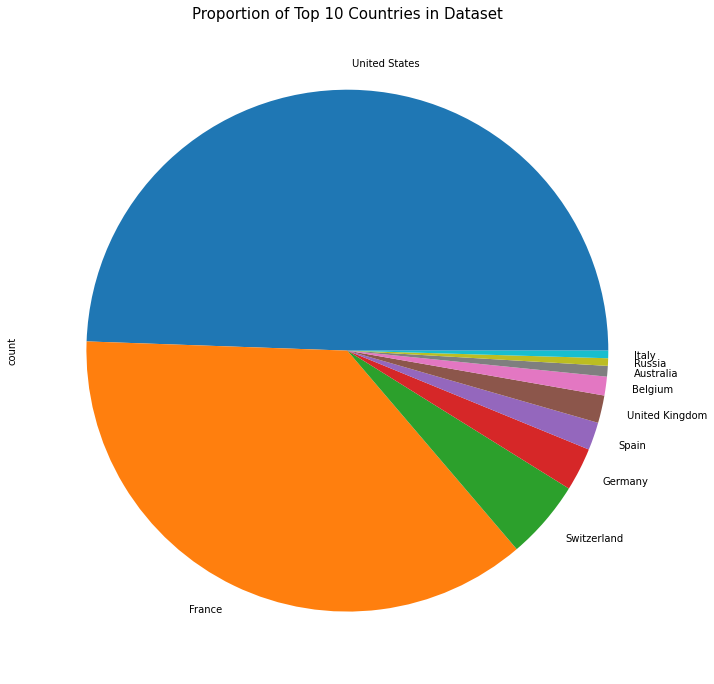

In [15]:
#Create figure large enough so that the text is visible and doesn't overlap
countries_df.head(10).plot(kind='pie', y='count', legend=False, figsize=(12, 12))
plt.title("Proportion of Top 10 Countries in Dataset", size = 15)

Top 10 countries with best average nutrition score
By averaging the nutrition score of all products for each country, we found the 10 countries in the dataset with the "healthiest" food.

In [16]:
#Mean and sort to find country with highest nutrition score
nutrition_df = score_country_df[['country','code','nutrition-score-fr_100g']]
nutrition_df = nutrition_df[nutrition_df['nutrition-score-fr_100g'].notna()]

nutrition_df = nutrition_df.groupby('country')['nutrition-score-fr_100g'].mean().reset_index()
nutrition_df = nutrition_df.sort_values('nutrition-score-fr_100g', ascending = False)
nutrition_df.head(10)

,country,nutrition-score-fr_100g
91,Pakistan,33.000000
12,Belarus,27.000000
6,Armenia,22.000000
132,Yemen,21.000000
68,Libya,21.000000
118,State of Palestine,21.000000
63,Jordan,21.000000
72,Madagascar,20.666667
56,Indonesia,20.000000
22,Cameroon,20.000000


Looking at products and the ingredients within these products and brands

## Products per Brand

Looking at how many products each brand has on the market.

First, let's take a look at how many products each brand has.

In [17]:
#looking at ingredients list of different products and brands
prod_ingred_df = df_open_food[['code', 'url', 'nutrition-score-fr_100g', 'product_name', 'brands', 'brands_tags', 'ingredients_text', 'additives']]
#look at the total number of brands represented
brands_agg = prod_ingred_df.groupby(['brands_tags'])['brands_tags'].count()
brands_agg.sort_values(ascending=False, inplace=True)
brands_agg 

brands_tags
carrefour                        3847
auchan                           3334
u                                2637
leader-price                     2228
casino                           2178
                                 ... 
jardins-de-carthage                 1
jarfin-bio                          1
jarritos                            1
jarritos,the-jel-sert-company       1
자연은,jayeon-eun                      1
Name: brands_tags, Length: 56804, dtype: int64

It seems like carrefour has the most brand tags with 3847. Let's look at some quick summary statistics on how many products each brand has.

In [18]:
#find the distribution of the data
print("The mean is", brands_agg.mean())
print("The median is", brands_agg.median())
print("The variance is", brands_agg.var())

The mean is 5.755879867614957
The median is 1.0
The variance is 1609.941795083433


Note the high variance in the summary statistics as well as the difference between the mean and the median. The difference between these two is most likely due to the high outlier brands that have a lot of products.

## The Most Common Ingredients
Let's take a look at the ingredients list column and the most commonly used ingredients

Now, we'll look at the ingredients and which ones are most popular. We'll first convert the ingredients text into a string type for us to parse through.

In [19]:
#convert these into strings then lists then explode for ingredients
prod_ingred_df['ingredients_text_str'] = prod_ingred_df['ingredients_text'].astype('str')
prod_ingred_df['ingredients_text_str'] = prod_ingred_df['ingredients_text_str'].str.split(',')

#separate the ingredients
prod_ingred_exploded_df = prod_ingred_df.explode('ingredients_text_str')

<ipython-input-19-1f4897cdfdab>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prod_ingred_df['ingredients_text_str'] = prod_ingred_df['ingredients_text'].astype('str')
<ipython-input-19-1f4897cdfdab>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prod_ingred_df['ingredients_text_str'] = prod_ingred_df['ingredients_text_str'].str.split(',')


Here we'll sort to find the top 10 most used ingredients and their counts.

In [20]:
#find the top 10 most popular ingredients
ingredients_plot = prod_ingred_exploded_df[prod_ingred_exploded_df['ingredients_text_str'] != 'nan']
ingredients_plot = ingredients_plot[['brands_tags', 'ingredients_text_str']]
ingredients_plot = ingredients_plot.groupby('ingredients_text_str').count().reset_index()
ingredients_plot.sort_values(by='brands_tags', inplace=True, ascending=False)

#show the top ten most used ingredients 
ingredients_plot.head(10)

,ingredients_text_str,brands_tags
342000,salt,81933
373331,sugar,51861
397032,water,47959
347998,sel,39508
370926,sucre,25850
138991,citric acid,24229
182644,eau,23265
280403,niacin,18915
176266,dextrose,17817
336485,riboflavin,17011


## Ingredient Word Cloud

Let's visualize this in a fun wordcloud using nltk!

Importing all the necessary components of our word cloud.

In [21]:
import nltk
nltk.download('punkt')
nltk.__version__

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


'3.7'

In [22]:
from nltk.corpus import stopwords

#Do stopword analysis
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Creation of our tokenize content function.

In [23]:
def tokenize_content(content):
  #tokenize text
  words = nltk.word_tokenize(content)
  #remove tokens that contain alphabetic characters 
  words = [word for word in words if word.isalpha()]
  #only alphabetic characters and convert them to lower case 
  words = [word.lower() for word in words if word.isalpha()]
  #remove stopwords
  words = [word for word in words if word not in stopwords]
  return words

In [24]:
#convert ingredient names to string
prod_ingred_df['ingredients_text_whole_str'] = prod_ingred_df['ingredients_text'].astype('str')
ingredients_names = prod_ingred_df[prod_ingred_df['ingredients_text_whole_str'] != 'nan']
ingredients_list = ingredients_names['ingredients_text_whole_str']

top_tokens_list = []
for brand in ingredients_list:
  top_tokens_list.append(tokenize_content(brand))

#flatten the list
top_tokens = []
for sublist in top_tokens_list:
  for item in sublist:
    top_tokens.append(item)

<ipython-input-24-d2749e6e7125>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prod_ingred_df['ingredients_text_whole_str'] = prod_ingred_df['ingredients_text'].astype('str')


Below we have the 20 most common ingredients used in products based on our tokenization.

In [25]:
#Find 20 most common words
import collections as col
top_most_common = col.Counter(top_tokens).most_common(20)
top_most_common

[('de', 409600),
 ('salt', 133267),
 ('sugar', 108374),
 ('oil', 96889),
 ('acid', 94887),
 ('water', 91747),
 ('flour', 80104),
 ('organic', 77116),
 ('corn', 73220),
 ('sodium', 72502),
 ('sel', 69209),
 ('milk', 68506),
 ('natural', 65858),
 ('wheat', 56744),
 ('sucre', 55847),
 ('syrup', 49353),
 ('eau', 45979),
 ('flavor', 45469),
 ('et', 41758),
 ('powder', 40998)]

Let's plot our wordcloud!

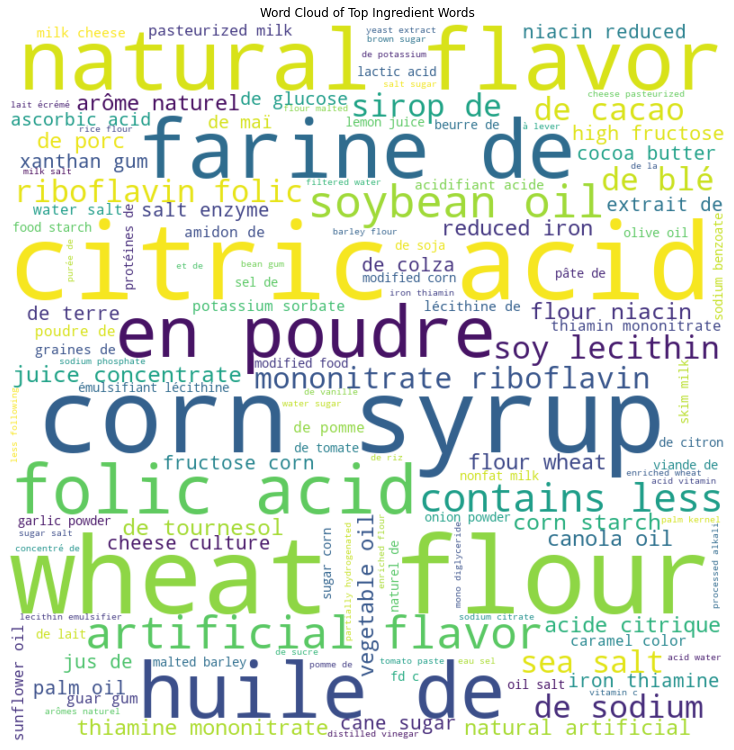

In [26]:
#make a word cloud for top tokens 
from wordcloud import WordCloud
#make the string 
text = ' '.join(top_tokens)

#feed it through the wordcloud function
wordcloud = WordCloud(width = 800, height = 800, min_font_size = 10, background_color = 'white').generate(text)

#show the figure
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title("Word Cloud of Top Ingredient Words")

plt.show()

## EDA for Nutrition

We have access to data about nutrition information, including energy, macronutrients (carbs, fat, protein), and other nutrients as well.

Let's rename some columns to make them easier to deal with

In [27]:
#Drop '100g' from each column name
df_open_food = df_open_food.rename(axis=1, mapper={"energy_100g": "energy", 
                                                   "fat_100g" : "fat", 
                                                   "saturated-fat_100g" : "saturated_fat", 
                                                   "carbohydrates_100g" : "carbohydrates", 
                                                   "sugars_100g": "sugars", 
                                                   "fiber_100g": "fiber", 
                                                   "proteins_100g" : "protein", 
                                                   "salt_100g": "salt",
                                                   "sodium_100g": "sodium"
                                                   })
print(df_open_food.dtypes)

code                                        object
url                                         object
creator                                     object
created_t                                   object
created_datetime                            object
last_modified_t                             object
last_modified_datetime                      object
product_name                                object
brands                                      object
brands_tags                                 object
countries                                   object
countries_tags                              object
countries_en                                object
ingredients_text                            object
serving_size                                object
additives_n                                float64
additives                                   object
ingredients_from_palm_oil_n                float64
ingredients_that_may_be_from_palm_oil_n    float64
nutrition_grade_fr             

We want to make sure all our data is valid, so we can drop any instance with a negative or overly large nutrition value. Ultimately, this does catch a few outliers that don't make practical sense. We also drop any instance with a NaN value.

In [28]:
#Removing anything above 1_000_000 and below 0 for either entry as they are not valid data (there exist negative values and and values > 1e6)
df_nutrients = df_open_food[["energy", "fat", "saturated_fat", "carbohydrates", "sugars", "fiber", "protein", "salt", "sodium"]]
df_nutrients = df_nutrients[(df_nutrients['energy'] >= 0) & (df_nutrients['energy'] <= 1_000_000) & 
                            (df_nutrients['fat'] >= 0) & (df_nutrients['fat'] <= 1_000_000) &
                            (df_nutrients['saturated_fat'] >= 0) & (df_nutrients['saturated_fat'] <= 1_000_000) & 
                            (df_nutrients['carbohydrates'] >= 0) & (df_nutrients['carbohydrates'] <= 1_000_000) &
                            (df_nutrients['sugars'] >= 0) & (df_nutrients['sugars'] <= 1_000_000) &
                            (df_nutrients['fiber'] >= 0) & (df_nutrients['fiber'] <= 1_000_000) &
                            (df_nutrients['protein'] >= 0) & (df_nutrients['protein'] <= 1_000_000) & 
                            (df_nutrients['salt'] >= 0) & (df_nutrients['salt'] <= 1_000_000) &
                            (df_nutrients['sodium'] >= 0) & (df_nutrients['sodium'] <= 1_000_000) 
                            ]
df_nutrients = df_nutrients.dropna(how="any")
df_nutrients.size

1780641

Creating a boxplot of all nutrients (excluding energy since it's not a nutrient and is larger than the other elements). We will remove outliers for now as they make the boxplot difficult to see

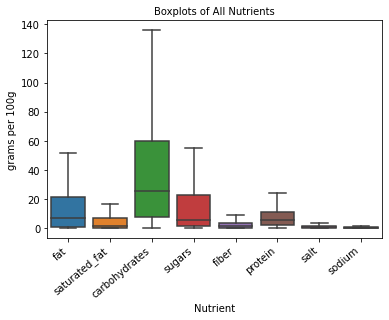

In [29]:
df_nutrients_plot = df_nutrients.drop(columns="energy")

#Remove outliers and set labels to be rotated for improved readability
ax_nutrients = sns.boxplot(data=df_nutrients_plot, showfliers=False)
ax_nutrients.set_xticklabels(ax_nutrients.get_xticklabels(), rotation=40, ha="right")
plt.title("Boxplots of All Nutrients" , size = 10 )
plt.ylabel("grams per 100g" , size = 10 )
plt.xlabel("Nutrient" , size = 10 )
plt.show()

Overall we see a healthy distribution with most foods having a median close to zero (which makes sense since a lot of foods don't have that ingredient, like spicy foods and sugar). In the case of fiber, salt, and sodium, the nutrients are overall quite low, whereas for sugars, carbohydrates, and fats, there are foods with high values.

Note that the macronutrients (fat, carbohydrates, and protein) are 3 of the features that have the biggest distribution. So, let's analyze their distribution further below.

Text(0.5, 0, 'Macronutrient')

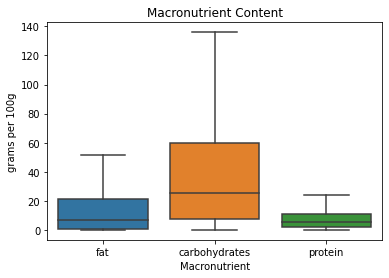

In [30]:
#Creating macronutrients_df
df_macronutrients = df_nutrients[["fat", "carbohydrates", "protein"]]
#sns.boxplot(data=df_macronutrients)
#Excluding outliers to get a better picture 
sns.boxplot(data=df_macronutrients, showfliers=False)
plt.title("Macronutrient Content")
plt.ylabel("grams per 100g" , size = 10 )
plt.xlabel("Macronutrient" , size = 10 )

There is a lot of variability in the carbohydrates, and a medium amount in the fat, but less in the protein. Also note the high median for carbs. This indicates that foods tend to have more carbs than the other 2 macronutrients, but also that the variability is high among foods for carb levels

We can also analyze correlations but creating a correlational heatmap of the relations between the various nutrition metrics

In [31]:
corr = df_nutrients.corr()

#Coolwarm is a good colorstyle to visualize with
corr.style.background_gradient(cmap ='coolwarm')


,energy,fat,saturated_fat,carbohydrates,sugars,fiber,protein,salt,sodium
energy,1.000000,0.765860,0.555783,0.547135,0.332232,0.204843,0.305759,-0.010552,-0.010552
fat,0.765860,1.000000,0.700154,-0.047538,0.002212,0.102577,0.263769,-0.005765,-0.005765
saturated_fat,0.555783,0.700154,1.000000,-0.010566,0.143723,0.009250,0.177162,-0.008495,-0.008495
carbohydrates,0.547135,-0.047538,-0.010566,1.000000,0.617922,0.179102,-0.095576,-0.014517,-0.014517
sugars,0.332232,0.002212,0.143723,0.617922,1.000000,-0.013310,-0.248632,-0.027672,-0.027672
fiber,0.204843,0.102577,0.009250,0.179102,-0.013310,1.000000,0.171301,-0.000985,-0.000985
protein,0.305759,0.263769,0.177162,-0.095576,-0.248632,0.171301,1.000000,0.013709,0.013708
salt,-0.010552,-0.005765,-0.008495,-0.014517,-0.027672,-0.000985,0.013709,1.000000,1.000000
sodium,-0.010552,-0.005765,-0.008495,-0.014517,-0.027672,-0.000985,0.013708,1.000000,1.000000


We see that salt and sodium are essentially the same item! This is important when we do machine learning analysis and look at feature selection. Also, energy seems to be correlated with the other macronutrients. This also makes sense, since carbs and protein are 4 calories/gram, and protein is 9 cals/gram, showing a direct relationship between these nutrients and energy. 

Again, notice how several variables are highly correlated with each other, such as sodium and salt (which are essentially the same thing), fat and energy, saturated_fat and fat, and sugars and carbohydrates.

# **4** Machine Learning to Determine Healthy Products

In this section, we are going to use a variety of supervised machine learning methods to regress on various features to determine their nutrition score. Then we are going to classify on several features to determine whether we can predict the "healthiness" of a product.

## Imports

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#Import random forest, neural networks
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPClassifier

#Import pytorch neural network classes
import torch
import torch.nn as nn

#Import helpers
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


We need to convert our response variable into a categorical variable that ML algorithms can predict the nutrition score. We also need to make sure that we remove any features that we may not need. We mostly want to keep information about the nutritional value of these food products. We are using the nutrition-score-fr_100g as the nutrition score index.

We will first clean in a very similar way done in the nutrition EDA

In [33]:
#Removing anything above 1_000_000 and below 0 for either entry as they are not valid data (there exist negative values and and values > 1e6)
df_open_food_nan = df_open_food[['additives_n', 'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n', 
                                'energy', 'fat', 'saturated_fat', 'carbohydrates', 'sugars', 'fiber', 'protein', 'salt', 'sodium','nutrition-score-fr_100g']]
df_open_food_nan = df_open_food_nan[(df_open_food_nan['energy'] >= 0) & (df_open_food_nan['energy'] <= 1_000_000) & 
                            (df_open_food_nan['fat'] >= 0) & (df_open_food_nan['fat'] <= 1_000_000) &
                            (df_open_food_nan['saturated_fat'] >= 0) & (df_open_food_nan['saturated_fat'] <= 1_000_000) & 
                            (df_open_food_nan['carbohydrates'] >= 0) & (df_open_food_nan['carbohydrates'] <= 1_000_000) &
                            (df_open_food_nan['sugars'] >= 0) & (df_open_food_nan['sugars'] <= 1_000_000) &
                            (df_open_food_nan['fiber'] >= 0) & (df_open_food_nan['fiber'] <= 1_000_000) &
                            (df_open_food_nan['protein'] >= 0) & (df_open_food_nan['protein'] <= 1_000_000) & 
                            (df_open_food_nan['salt'] >= 0) & (df_open_food_nan['salt'] <= 1_000_000) &
                            (df_open_food_nan['sodium'] >= 0) & (df_open_food_nan['sodium'] <= 1_000_000) 
                            ]

#also drop any Nan values
df_open_food_nan = df_open_food_nan.dropna(how="any")

# select helpful features for our machine learning algorithm
df_open_food_ml = df_open_food_nan[['additives_n', 'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n', 
                                'energy', 'fat', 'saturated_fat', 'carbohydrates', 'sugars', 'fiber', 'protein', 'salt', 'sodium', 'nutrition-score-fr_100g']]

#see the size of the dataset
len(df_open_food_nan)

190770

Now we need to split the nutrition score where we categorize foods that have a score higher or equal to the median is "healthy" (1), and anything below is "unhealthy" (0). This is because we believe that health_score is a good indicator of a nutrition score.   

This variable will be used for classification analyses, whereas the score itself can be used for regression and real-number analyses.

In [38]:
#finding the median score of the nutrition score
median_score = df_open_food_ml[['nutrition-score-fr_100g']].median()

#creating the categorical response variable
df_open_food_ml['health_score'] = np.where(df_open_food_ml[['nutrition-score-fr_100g']] >= median_score, 'healthy', 'unhealthy')
df_open_food_ml['nutrition-score-fr_100g'].describe()

additives_n                                145117
ingredients_from_palm_oil_n                145117
ingredients_that_may_be_from_palm_oil_n    145117
energy                                     145117
fat                                        145117
saturated_fat                              145117
carbohydrates                              145117
sugars                                     145117
fiber                                      145117
protein                                    145117
salt                                       145117
sodium                                     145117
nutrition-score-fr_100g                    145117
health_score                               145117
dtype: int64


count    190770.000000
mean          8.672910
std           9.027616
min         -15.000000
25%           1.000000
50%           9.000000
75%          16.000000
max          40.000000
Name: nutrition-score-fr_100g, dtype: float64

## Separating Features and Response

In [ ]:
#stores features dataframe into variable called "features"
features = df_open_food_ml.loc[:, ~df_open_food_ml.columns.isin(['nutrition-score-fr_100g', 'health_score'])]



In [ ]:
#check correlation between features
corr = features.corr()
corr.style.background_gradient(cmap ='coolwarm')

,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,energy,fat,saturated_fat,carbohydrates,sugars,fiber,protein,salt,sodium
additives_n,1.000000,0.117145,0.291698,0.018059,-0.083061,-0.017723,0.159443,0.155856,-0.110501,-0.102294,0.002580,0.002580
ingredients_from_palm_oil_n,0.117145,1.000000,0.177724,0.097651,0.056455,0.087469,0.082595,0.061974,0.003197,-0.015889,-0.002056,-0.002056
ingredients_that_may_be_from_palm_oil_n,0.291698,0.177724,1.000000,0.019535,0.015635,0.035809,0.018420,0.012664,-0.028205,-0.048269,-0.003513,-0.003513
energy,0.018059,0.097651,0.019535,1.000000,0.767079,0.555481,0.547232,0.330476,0.212487,0.307014,-0.009974,-0.009974
fat,-0.083061,0.056455,0.015635,0.767079,1.000000,0.699610,-0.049427,-0.001881,0.109145,0.267144,-0.005800,-0.005800
saturated_fat,-0.017723,0.087469,0.035809,0.555481,0.699610,1.000000,-0.013148,0.140358,0.010702,0.178800,-0.008931,-0.008931
carbohydrates,0.159443,0.082595,0.018420,0.547232,-0.049427,-0.013148,1.000000,0.619447,0.185316,-0.100950,-0.014654,-0.014654
sugars,0.155856,0.061974,0.012664,0.330476,-0.001881,0.140358,0.619447,1.000000,-0.014625,-0.252968,-0.027699,-0.027699
fiber,-0.110501,0.003197,-0.028205,0.212487,0.109145,0.010702,0.185316,-0.014625,1.000000,0.177822,-0.003291,-0.003291
protein,-0.102294,-0.015889,-0.048269,0.307014,0.267144,0.178800,-0.100950,-0.252968,0.177822,1.000000,0.013052,0.013052


Through this heat map we are able to see that there are several features that are highly correlated with each other. For example, sodium and salt are nearly identical, and fat and energy are highly correlated. As a result, we will be removing them from the features used.

In [ ]:
#dropped features with high correlations
features = features.drop(columns = ['sodium', 'ingredients_from_palm_oil_n', 'energy'])

#store the classification target variable
nutrition_score = df_open_food_ml['health_score']

#store the regression target variable 
nutrition_regression = df_open_food_ml['nutrition-score-fr_100g']

## Splitting into Training and Test Set For Regression

In [ ]:
#Assign appropriate value to seed and conduct 80/20 train-test split with random_state = seed 
seed = 42
X = features
y = nutrition_regression

x_train, x_test, y_train, y_test = train_test_split(X, y, shuffle=True,
                                   test_size=0.20, random_state=seed)

## **4.1** Regression Models to Predict Nutrition Scores

In this section we are going to use several models to regress on our nutrition score (nutrition-score-fr_100g) to see which model is the most effective.

### Unregularized OLS Regression

Firstly, we are going to create a linear regression without regularization to see how well we are able to predict a health score based on a simple OLS without regularization.  

This is a good baseline to check for weights of features, scores, and mean squared error.

In [ ]:
# initialize the model and fit it on the training set
reg = LinearRegression()
reg.fit(x_train, y_train)

# predict on the test set 
y_pred = reg.predict(x_test)

# calculate the R-squared score
score = reg.score(x_train, y_train)
test_score = reg.score(x_test, y_test)
print("R^2 score for TRAIN: " + str(score))
print("R^2 score for TEST: " + str(test_score))

# calculate the MSE
print("MSE for TEST: " + str(mean_squared_error(y_pred, y_test)))

# estimated coefficients
print("Coefficients determined: " + str(reg.coef_))

R^2 score for TRAIN: 0.6649442567890541
R^2 score for TEST: 0.6742535216195189
MSE for TEST: 26.44689636308995
Coefficients determined: [ 0.50719621 -0.61790369  0.18149993  0.4489247   0.01402693  0.19159877
 -0.21162959  0.10941375  0.03342987]


The $R^2$ scores are decent, and the MSE is quite low. This means we are off by avout 5, on average. The coefficients are alsot mostly significant, and sending them to zero is not desired. So we predict using Ridge will do better than Lasso

### Ridge Regression

We use the `RidgeCV` class in to perform $L_2$ Regularized Linear Regression. We initialize a Ridge regression model named `reg_ridge`, with alpha set to 10.0 through cross validation.

We saved our $R^2$ score as a variable called `ridge_score`.

In [ ]:
# initialize the Ridge model and fit it on the training set using cross-validation
reg_ridge = RidgeCV()
reg_ridge.fit(x_train, y_train)

# predict on the test set 
y_pred = reg_ridge.predict(x_test)

# calculate the R-squared score
ridge_score = reg_ridge.score(x_train, y_train)
ridge_test_score = reg_ridge.score(x_test, y_test)
print("R^2 score for TRAIN: " + str(ridge_score))
print("R^2 score for TEST: " + str(ridge_test_score))

# calculate the MSE
print("MSE for TEST: " + str(mean_squared_error(y_pred, y_test)))

# estimated coefficients
print("Coefficients determined: " + str(reg_ridge.coef_))
print("Alpha determined: " + str(reg_ridge.alpha_))

R^2 score for TRAIN: 0.6649442564594649
R^2 score for TEST: 0.6742538378393168
MSE for TEST: 26.446870689651323
Coefficients determined: [ 0.50717065 -0.61726094  0.18149987  0.44892287  0.014027    0.19159926
 -0.21162976  0.10941451  0.03342991]
Alpha determined: 10.0


Overall: Similar (but not equal!) performance. Also, note the similar $R^2$ scores between train and test in both cases, which is evidence that there is no significant under/overfitting

### Lasso Regression 

We use the `LassoCV` class in to perform $L_1$ Regularized Linear Regression. We initialize a Ridge regression model named `reg_lassocv`. Through cross validation, our alpha was automatically set to approx. 4.22.

We saved our $R^2$ score as a variable called `lassocv_score`.

In [ ]:
# initialize the model with alpha = 5 and fit it on the training set
reg_lassocv = LassoCV()
reg_lassocv.fit(x_train, y_train)

# predict on the test set 
y_pred = reg_lassocv.predict(x_test)

# calculate the R-squared score
lassocv_score = reg_lassocv.score(x_train, y_train)
lassocv_test_score = reg_lassocv.score(x_test, y_test)
print("R^2 score for TRAIN: " + str(lassocv_score))
print("R^2 score for TEST: " + str(lassocv_test_score))

# calculate the MSE
print("MSE for TEST: " + str(mean_squared_error(y_pred, y_test)))

# estimated coefficients
print("Coefficients determined: " + str(reg_lassocv.coef_))
print("Alpha determined: " + str(reg_lassocv.alpha_))

R^2 score for TRAIN: 0.6645896458295648
R^2 score for TEST: 0.6738916872104344
MSE for TEST: 26.47627318756166
Coefficients determined: [ 0.46618103 -0.          0.1815399   0.44525475  0.01399487  0.19196677
 -0.20870086  0.10736205  0.03286744]
Alpha determined: 0.13790237376277725


Based off the results of the $R^2$ score of the unregularized, Ridge, and Lasso models, we see that there is little difference overall, but the Lasso seems to do marginally worse than OLS.  

Notice that Ridge is supposed to add a penalty to features with large weights (or coefficients) in an attempt to reduce overfitting. Lasso is supposed to push features that are insignificant to 0 in an attempt to reduce overfitting.  

Lasso is best when there are a few features that contribute a lot to the model. If we continued to push `alpha` bigger, we would see accuracy of Ridge and Lasso decrease as we are essentially reaching an intercept model, which obviously is less accurate than an unregularized linear model. 

In terms of looking at the bias-variance tradeoff, we also did not note any significant underfitting or overfitting in our analysis, as the training and test scores for the above regression models were very similar. The model also was quite stable when trying different versions (OLS, L1, L2), also showing a proper fit of the model. An MSE of around 26 (RMSE of around 5.14) is also quite solid for our model.

### PCA on Regression Models

We can try PCA on our linear regression model to see if only picking out prominent features will help our $R^2$ score. However, since PCA is much like Lasso in the sense that some features are "removed", we would expect PCA to do worse than the unregularized linear model, because it seems that the features all slightly contribute to the model. However, we can still run PCA on our regression features as a double check!   

This is also a way to remove some residual multicollinearity we had in the data

PCA is not scale-invariant so we need to first standardize the data in order to help us to choose the right number of Principal Components. We also save the explained variance ratios and cumulative explained variance ratios to use for our plot later. 

In [ ]:
# Standardizing the features between 0 and 1
# create a Scaler object and fit it to your training data
scaler = StandardScaler().fit(x_train)
x_train_1 = scaler.transform(x_train)

#Instantiate and Fit PCA
pca = PCA(n_components=9)
x_1 = pca.fit_transform(x_train_1)

#Save the explained variance ratios
explained_variance_ratios = pca.explained_variance_ratio_

#Save the CUMULATIVE explained variance ratios
cum_evr = np.cumsum(explained_variance_ratios)

Now that we've done our preliminary step, let's plot the explained variance ratio to see how many Principal Components we should pick. We're shooting for 85% of our variance to be explained by the number of Principal Components we pick, since this is the value we used in this course.

<Figure size 1152x720 with 0 Axes>

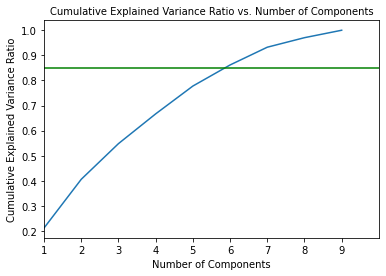

In [ ]:
# Plot
plt.figure(figsize =(16,10))
fig, ax = plt.subplots()
plot = sns.lineplot(x=range(1,(len(cum_evr)+1)), y=cum_evr, ax = ax)
ax.set_xlim(1,10)
ax.set_xticks(range(1, 10))
plot.axhline(0.85, color = "green")

# Set label for x-axis
plt.xlabel( "Number of Components" , size = 10 )
  
# Set label for y-axis
plt.ylabel( "Cumulative Explained Variance Ratio" , size = 10 )
  
# Set title for figure
plt.title( "Cumulative Explained Variance Ratio vs. Number of Components" , size = 10 )

plt.show()

It seems that ~6 is the number of components that explains 85% of the variance. We'll go with 6 in this example. Let's transform our regression features to reflect this.

In [ ]:
#Refit and transform on training with parameter n = 6
pca = PCA(n_components=6)
x_2 = pca.fit_transform(x_train_1)

#Transform on Testing Set
x_test_1 = scaler.transform(x_test)
x_test_pca = pca.transform(x_test_1)

Finding the $R^2$ score of the linear regression after PCA is run. If what we predicted is correct, the $R^2$ score should be lower than the linear regression without PCA.

In [ ]:
#Initialize model with default parameters and fit it on the training set
pca_linear_reg = LinearRegression()
pca_linear_reg.fit(x_2, y_train)

#predict on test set
y_pred = pca_linear_reg.predict(x_test_pca)

#finding r-squared
pca_score = pca_linear_reg.score(x_2, y_train)
print(pca_score)

pca_test_score = pca_linear_reg.score(x_test_pca, y_test)
print(pca_test_score)

0.6526377142942905
0.6652102204578528


As expected, running PCA on our linear regression model actually seems to yield a similar effect to the Lasso model, and actually slightly lowers the $R^2$ score as well. In the heat map presented earlier in the project, we notice how there are several features that seem to be highly correlated and we would expect PCA to remove those correlated features and only keep features that explain a majority of the variance. 

## Neural Network

We also created a simple sklearn Neural Network model to predict the healthiness of food products. The complexity of the model dramatically increased the number of parameters learned, and the introduction of hidden relu activation layers introduced nonlinearity to the model, leading to a higher $R^2$ score. Since there is no inherent reason for nutrition to be linear, this also aims to capture a potential non-linear trend. 

In [ ]:
#sklearn implementation
from sklearn.neural_network import MLPRegressor
num_hidden1 = 8
num_hidden2 = 6
neural_net = MLPRegressor(hidden_layer_sizes = (num_hidden1, num_hidden2), 
                          activation = 'relu', solver='adam')
neural_net.fit(x_train, y_train)
predictions = neural_net.predict(x_test)


In [ ]:
#evaluating neural network model
nn_train_score = neural_net.score(x_train, y_train)
nn_test_score = neural_net.score(x_test, y_test)

# Score calculations
print("R^2 score for TRAIN: " + str(nn_train_score))
print("R^2 score for TEST: " + str(nn_test_score))

# calculate the MSE
print("MSE for TEST: " + str(mean_squared_error(y_pred, y_test)))

R^2 score for TRAIN: 0.9601482783698304
R^2 score for TEST: 0.9592074146248808
MSE for TEST: 27.181109207974313


Interestingly enough, we get quite high $R^2$ values, indicating that we can capture a vast majority of the variance in $y$ with our input data. This makes sense given the increased complexity and potential non-linear interactions. However, the MSE is actually slightly higher for the test data! This means that although we capture the trend better, we are likely to be more off (on average!) using the neural network than regression

## **4.2** Using macronutrients to Predict Healthiness

### Creating features and test/train split

For this portion, our only features will be macronutrients, since these are more readily available for unknwon foods and are common ways to measure how "good" a food is. 

In [ ]:
#Select the necessary features and print the shape
X_macro = features[["carbohydrates", "fat", "protein"]]
print(X_macro.shape)
print(nutrition_score.shape)

(190770, 3)
(190770,)


Create a standard test-train split using an 80/20 split

In [ ]:
#Assign appropriate value to seed and conduct 80/20 train-test split with random_state = seed
seed = 42
y_macro = nutrition_score

X_train_macro, X_test_macro, y_train_macro, y_test_macro = train_test_split(X_macro, y_macro, shuffle=True,
                                   test_size=0.20, random_state=seed)

### Classification Models: Logistic Regression

As a baseline, let's run a standard logistic regression on the data (without any regularization) to see the accuracies we can get.   

Note that there is inherently no class imbalance here because we feature engineered our y-variable to be postive/negative based on comparing it to the median, meaning we have a 50/50 split. Therefore, using accuracies is valid.

In [ ]:
# Initialize model with default parameters and fit it on the training set
log_reg = LogisticRegression()
log_reg.fit(X_train_macro, y_train_macro)

# Use the model to predict on the test set and save these predictions as `y_pred`
y_pred = log_reg.predict(X_test_macro)

# Find the accuracy and store the value in `log_acc`
log_acc = accuracy_score(y_pred, y_test_macro)
print("Training accuracy: " + str(log_reg.score(X_train_macro, y_train_macro)))
print("Testing accuracy: " + str(log_reg.score(X_test_macro, y_test_macro)))


Training accuracy: 0.8118807988677466
Testing accuracy: 0.8124443046600619


This is pretty good! Also note the similar scores between train/test.     

We can also look our confusion matrix and calculate the $F1$ score to ensure there is no weird behavior between classes


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

# evaluation of Logistic Model
print(confusion_matrix(y_test_macro, y_pred))
print(f1_score(y_test_macro, y_pred, pos_label = 'healthy'))

[[15777  3919]
 [ 3237 15221]]
0.8151382071816068


As expected, both classes behave the same and there are similar amounts of false negatives and false positives. The $F1$ score is satisfactory.

### Correlation analysis and PCA if needed

As we move into regularized models and regression, we want to remove correlated features. In EDA and 4.1, we saw correlations between these 3 entities, so we want to remove them via PCA to remove any multicollinearity that will hurt future models.

In [ ]:
X_macro.corr() 



,carbohydrates,fat,protein
carbohydrates,1.000000,-0.049427,-0.100950
fat,-0.049427,1.000000,0.267144
protein,-0.100950,0.267144,1.000000


The table has several values with an absolute value > 0.1, so PCA will be good to remove multicolinearity.  

Also note that as we move into regression, we need the real-valued scores and not the binarized version.

In [ ]:
#Need real values (nutrition score), not binarized good/bad
y_score = df_open_food_ml['nutrition-score-fr_100g']
X_train_score, X_test_score, y_train_score, y_test_score = train_test_split(X_macro, y_score, shuffle=True,
                                   test_size=0.20, random_state=seed)

We can run PCA in a similar way we have done in the past: standardizing the data, fit_transform to the training data, and doing the same to the test data.   

In [ ]:
#PCA
scaler = StandardScaler()

scaler.fit(X_train_score)
scaled_X_train = scaler.transform(X_train_score)
scaled_X_test = scaler.transform(X_test_score)

pca = PCA(n_components=scaled_X_train.shape[1])
pca_X_train = pca.fit_transform(scaled_X_train)
pca_X_test = pca.fit_transform(scaled_X_test)

#Variance captured analysis 
explained_variance_ratios = pca.explained_variance_ratio_
cum_evr = np.cumsum(explained_variance_ratios)
print(cum_evr)
print(pca_X_train.shape)

[0.43317333 0.7577854  1.        ]
(152616, 3)


Since we only have 3 features and using 2 features does not capture most of the variance (see plot below), we will use all 3 principal components. 

### Regression models: Elastic Net

Given the small number of input features, its not worth figuring out feature importance and resultant desired behavior (ex. pushing weights to zero via L1 or shrink via L2), so an elastic net is used for ratios ranging from 0.0 to 1.0.
The ElasticNetCV Library allows us to cross-validate in a simple function call by specifying the number of folds to validate with (cv=5)

In [ ]:
#PCR to predict the actual score using elastic net (PCA as input)

#Use different ratios of L1 (1.0) and L2 (0.0) in the elastic net
ratios = [i/100 for i in range(1, 101)]

#Use CV
elastic = ElasticNetCV(l1_ratio=ratios, cv=5) #Valid range of alphas are automatically tested 

#Fit and predict
model = elastic.fit(pca_X_train, y_train_score)
y_pred = model.predict(pca_X_test)

**Parameter and MSE analysis for elastic net**

In [ ]:

print("Alpha chosen: " + str(model.alpha_))
print("Coefficients: " + str(model.coef_))
print("L1 ratio chosen: " + str(model.l1_ratio_))
print("R^2 Score for TRAIN: " + str(model.score(pca_X_train, y_train_score)))
print("R^2 Score for TEST: " + str(model.score(pca_X_test, y_test_score)))
print("Test MSE: " + str(mean_squared_error(y_pred, y_test_score)))
print("Train MSE: " + str(mean_squared_error(model.predict(pca_X_train), y_train_score)))

Alpha chosen: 0.0040486647687908925
Coefficients: [ 2.35998276  4.18407394 -3.34148818]
L1 ratio chosen: 1.0
R^2 Score for TRAIN: 0.39718016935361555
R^2 Score for TEST: 0.3994992712505223
Test MSE: 48.753805776059764
Train MSE: 49.174478352128375


Overall, we see the parameters chosen are a very low alpha and a complete focus on L1 regularization. The coefficients are all significantly non-zero, but note they are for the principal components and not for the macronutrient themselves, so there is not much interpretability here. 

The $R^2$ values are quite low here, only about 0.4 (similar again for test and train!). The MSE is not bad at all given that we only have 3 features, but is still quite a bit higher than the ~25 we were getting in 4.1 (but again, similar between test and train indicating lack of overfit!). Let's try something more complex.

### Regression Models: Random Forests

While logistic regression does a decent job at deciding a valid cut-off, our performance increase from regression to neural network in 4.1 shows inherent nonlinearities within the data.   

Here, we use RandomForests to regress our data to add more complexity.

We can use cross-validation to pick the ideal n_estimators and max_depth for random forests. **This takes ~15 minutes to run because of the loops needed for cross-validation that produces 9 iterations!**

Ideally, more combinations n_estimators would be tested, but this causes too much time/computing power to run effectively.

In [ ]:
random_seed = 42
depths = [1, 2, 3] #Only 3 features 
n_estimators = [200*i for i in range(1, 4)]
mse = []
import sklearn
print(sklearn.metrics.SCORERS.keys())
for depth in depths: 
  for n_est in n_estimators: 
    print("next iter") #Keep track when the model is finished
    rf = RandomForestRegressor(random_state=random_seed, max_depth=depth, n_estimators=n_est)
    cv = KFold(n_splits=5).get_n_splits(pca_X_train, y_train_score)
    scores = cross_val_score(rf, pca_X_train, y_train_score, cv=cv, scoring='neg_mean_squared_error')
    mse.append(abs(np.mean(scores)))
print(mse)
print(np.argmin(mse))

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

The results from running cell (if you don't have 15 minutes) are: 


```
MSE: [59.09639375429904, 59.102198417439126, 59.10936757856681, 49.30632169462469, 49.36827237522546, 49.40105322143889, 40.79416782775635, 40.84685514089898, 40.87357334867751]
Argmax index: 2
Argmin index: 6
```


From cross-validation, we get that the idea hyperparameter set is n_est = 200, max_depth = 3. We can train this model on the whole training set and test it on the test set to get the corresponding score and mean squared error.

In [ ]:
#[59.09639375429904, 59.102198417439126, 59.10936757856681, 49.30632169462469, 49.36827237522546, 49.40105322143889, 40.79416782775635, 40.84685514089898, 40.87357334867751]
#argmin index -> 6

depth=3
n_est=200
random_seed = 42
rf = RandomForestRegressor(random_state=random_seed, max_depth=depth, n_estimators=n_est)
rf.fit(pca_X_train, y_train_score)
y_pred = rf.predict(pca_X_test)


Print out metrics (without having to re-run!)

In [ ]:
print("R^2 Score for TRAIN: " + str(rf.score(pca_X_train, y_train_score)))
print("R^2 Score for TEST: " + str(rf.score(pca_X_test, y_test_score)))
print("Test MSE: " + str(mean_squared_error(y_pred, y_test_score)))
print("Train MSE: " + str(mean_squared_error(rf.predict(pca_X_train), y_train_score)))

R^2 Score for TRAIN: 0.4788927342010001
R^2 Score for TEST: 0.4767730600160959
Test MSE: 42.48005603906526
Train MSE: 42.50885033707778


These results are far better than our elastic net metrics. We obtain an $R^2$ value of nearly 0.5 (as opposed to ~0.39) and our mean-squared-error has decreased to around 42 (as opposed to ~50). 

Again, note similar values between train and test indicating lack of overfitting.   

Overall: We are off by about 6-7 (on average) for each prediction, which is worse than our 4.1 model, but with a LOT less information. Only given macronutrient information (carbs, fat, protein), we built a pretty accurate classifier and regressor to calculate its nutrition score. 

**Side note: why no NNs:(?**   
A: Only 3 input features makes this a weak candidate for complex models like neural networks and will likely cause overfitting.

# **5** Conclusion: Summary of al analyses and findings

Through the Open Food Facts Kaggle dataset, we are able to clean, explore, analyze, and model food facts data through various lenses. After mounting the Kaggle dataset and some data cleaning, we were able to do some exploratory data analysis on the dataset. As a first step, we wanted to get an idea of which countries the majority of the food products were coming from, as this might have an influence on nutrition and which cuisines were represented -- US and France had the highest product counts. We also found the countries with healthiest foods in the dataset, based on nutrition score, with Pakistan at the top of the list. Next, we looked at the ingredients list column and broke it down. The motivation for this was to see the most common ingredients across various products in the dataset. We then ordered and found the top ingredients, some of which include salt and oil. To visualize this, we put it in a wordcloud through nltk. We then looked at the nutrients section of the data and plotted boxplots of each nutrient present (with outliers removed as it hurt visualization), and found that most foods tend to have low-to-none values for most nutrients but the macronutrients have high variability. Creating another boxplot set for the macronutrients showed higher variability in carbohydrates than protein and fat.

In terms of modeling, we mainly wanted to regress on a product’s various features to predict its nutrition score. Firstly, we noticed that there is multicolinearity between some features, such as salt and sodium, so we removed features that showed high colinearity. To achieve regression on nutrition score, we ran an unregularized linear regression, a PCA linear regression, a LASSO linear regression (with cross-val), and a Ridge linear regression (with cross-val). We noticed that the linear and ridge regressions (roughly 0.67 R-squared score) had similar R-squared scores while LASSO and PCA linear regression (roughly 0.62 R-squared score) performed not as well as the previous models. We suspect that this is because the features all contribute to the model to some extent where removing features or forcing features to zero would actually lower accuracy. We also ran a simple neural network model to predict nutrition score with the same features using the sklearn library, with two hidden layers. The model yielded a surprisingly high accuracy score (approx 0.96 R-squared score) on both the training and test sets; this may be due to the nonlinearity the relu layers of the model introduced, in contrast to the previous few models. 
Our second goal was to be able to classify products exclusively on macronutrient features to predict whether a product is “healthy” or not based on a binary version of nutrition score. Using simple logistic regression as a baseline, we were able to get an accuracy of above 0.81 using only fat, protein, and carbs. We then analyzed the data and saw multicollinerity, so PCA was run with all principal components kept (3). Given the small number of features, elastic net was used since it was hard to determine whether pushing weights to zero (L1) or holistically reducing them (L2) is ideal. The elastic net (with cross-val) got an R^2 score of about 0.39 with an MSE of around 50 - worse than our previous regressors, but using a lot less data. To increase model complexity, we used a RandomForestRegressor with cross-validation and got an R^2 score of ~0.48 and an MSE of around 42.5. Using only 3 features, these values are incredibly impressive at calculating various foods' nutrition scores.

Overall, we were able to conduct some exploratory data analysis and modeling on the Open Food Facts dataset. Moving forward, we can conduct more exploratory data analysis on other variables within the dataset, such as exploring the URL and conducting web scraping to gain more information about each product. It would also be helpful to look more at the effectiveness of various other models, such as boosting and even deep learning models. 


We learned a lot about visualization, correlations, statistics, machine learning classification, and machine learning regression during this project. We hope to apply these models into our own lives and predict the healthiness of the foods we snack on!